## 1. Import libraries

In [165]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [166]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

## 2. Import data

In [167]:
path = r'C:\Users\Niklas Winter\Layoffs Analyse'

In [168]:
# 2.Importing data set Layoffs
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'country_vaccinations.csv'))


In [169]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/Unrate')

In [170]:
# Set Quandl API key
quandl.ApiConfig.api_key = "zSHwDAf6bNAN21F8QQUg"


In [171]:
data.head()

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [172]:
data.columns

Index(['Value'], dtype='object')

In [173]:
data.shape

(889, 1)

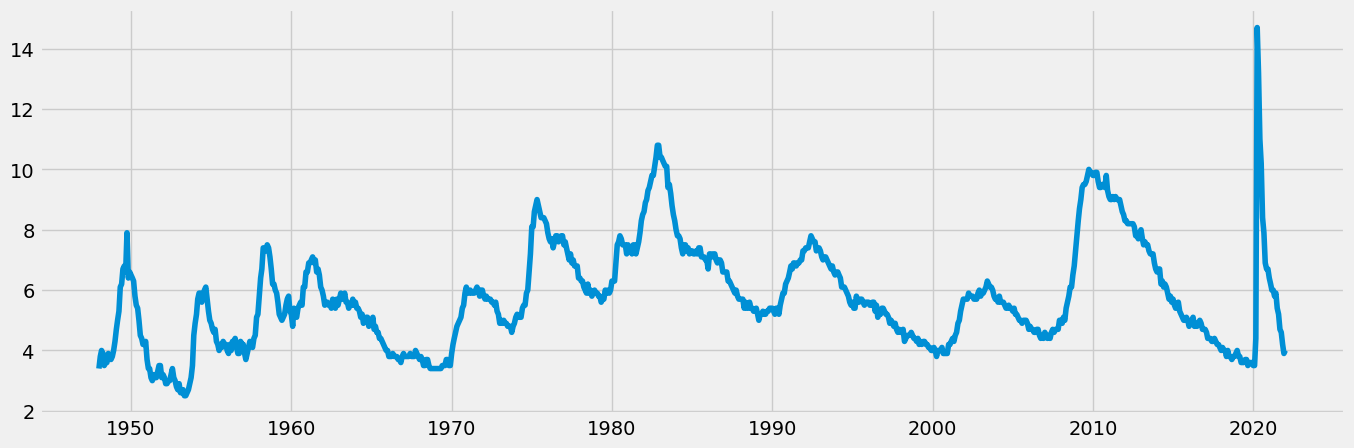

In [174]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

## 2. Subsetting, wrangling, and cleaning time-series data


In [175]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [176]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2023-03-01')]

### I want to see the impact of the Covid-19 pandemic in comparison to latest crises  within the last 30 years. The reason for the timeframe is the impact of globalisation and its start due to the information technologies and better ways of transportation which had a big influence of the dynamic of these crises.

In [177]:
data_sub.shape

(265, 2)

In [178]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0


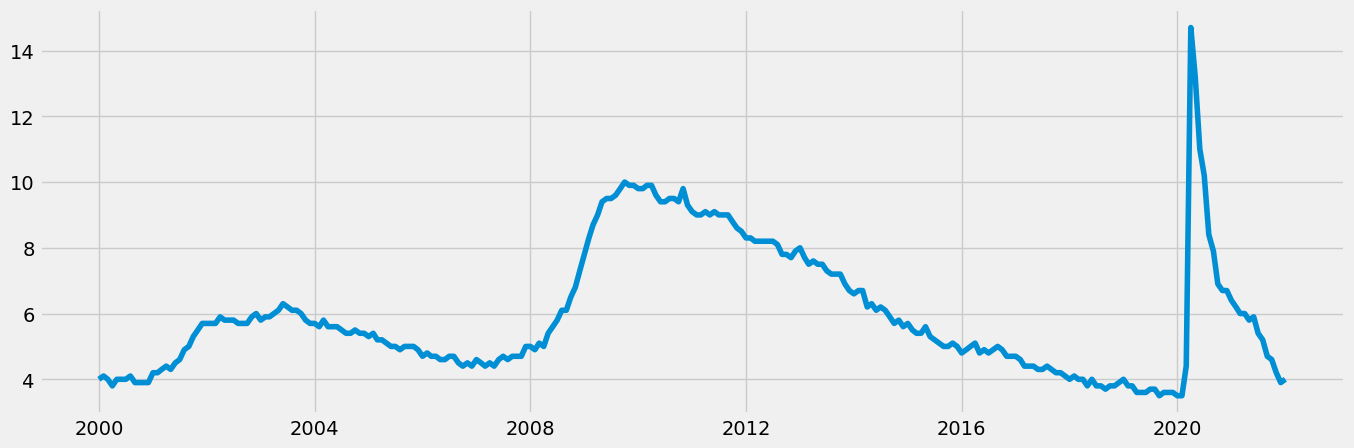

In [179]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### The econonmic crisis had a strong impact on the unemployment rates!

In [180]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [181]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

201

## 3. Time-series analysis: decomposition

In [182]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [183]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

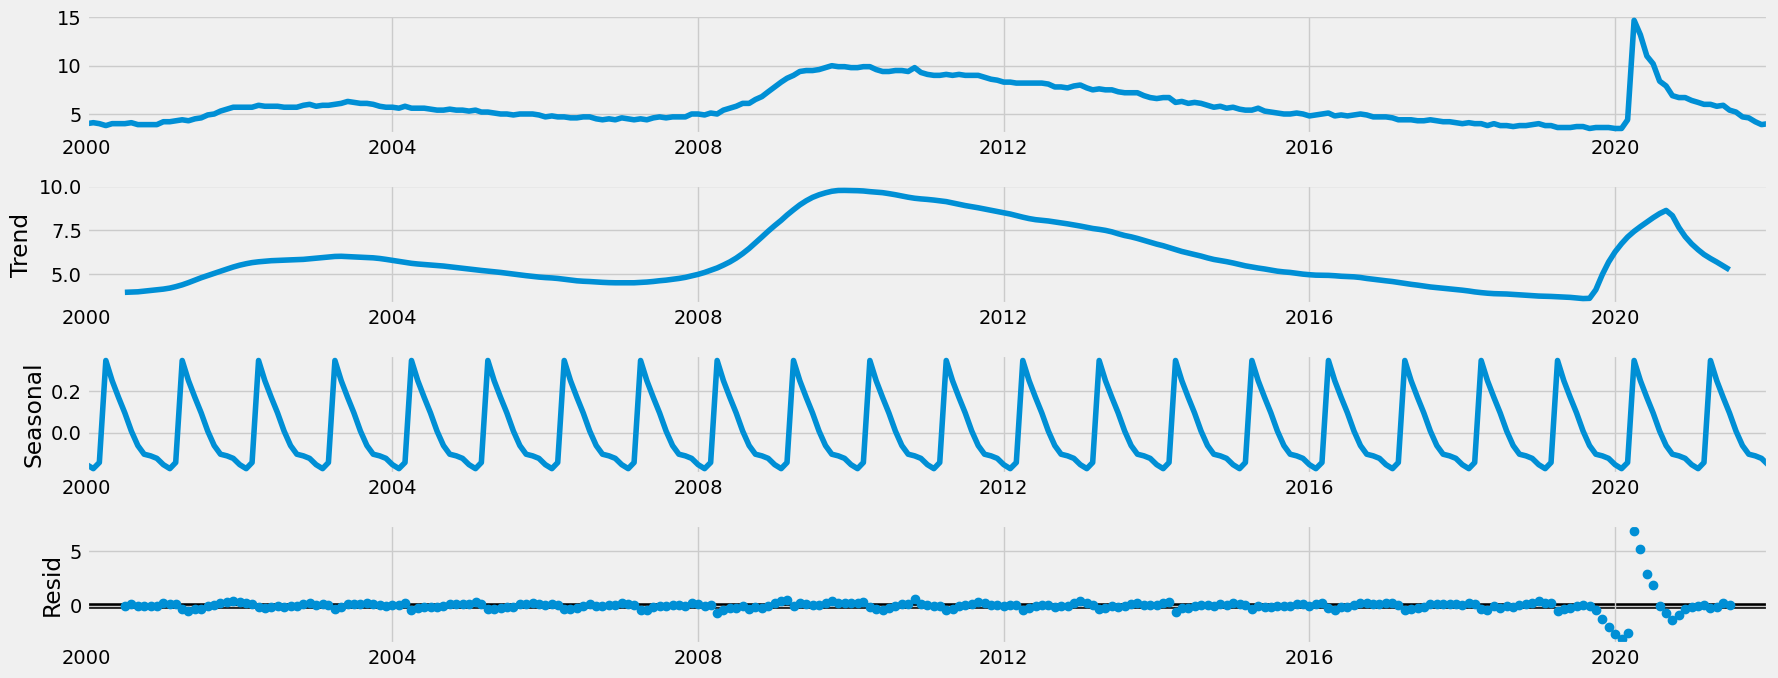

In [184]:
# Plot the separate components

decomposition.plot()
plt.show()

## 4. Testing for stationarity

In [185]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.931426
p-value                          0.041814
Number of Lags Used              0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


#### The Dickey-Fuller test indicate that there is some evidence to suggest that the time series is stationary, as the test statistic is negative and the p-value is below 0.05, which suggests that we can reject the null hypothesis that the time series is non-stationary. No lags were used in the test, which suggests that the time series may not have any autocorrelation. 

## 5. Stationarizing the Civilian Unemployment Rate

In [194]:
data_diff = data_sub.diff().dropna()
dickey_fuller(data_diff['Value'])


Dickey-Fuller Stationarity test:
Test Statistic                -1.255406e+01
p-value                        2.173897e-23
Number of Lags Used            1.000000e+00
Number of Observations Used    2.620000e+02
Critical Value (1%)           -3.455558e+00
Critical Value (5%)           -2.872636e+00
Critical Value (10%)          -2.572683e+00
dtype: float64


In [195]:
#### The Dickey-Fuller Stationarity test on the differenced time series (data_diff) returned a test statistic value of -12.55406 which is smaller than all critical values (-3.455365, -2.872551, and -2.572638) at the 1%, 5%, and 10% significance levels. The p-value is also very small (2.173897e-23) which indicates strong evidence against the null hypothesis of non-stationarity. Therefore, we can conclude that the differenced time series is stationary.

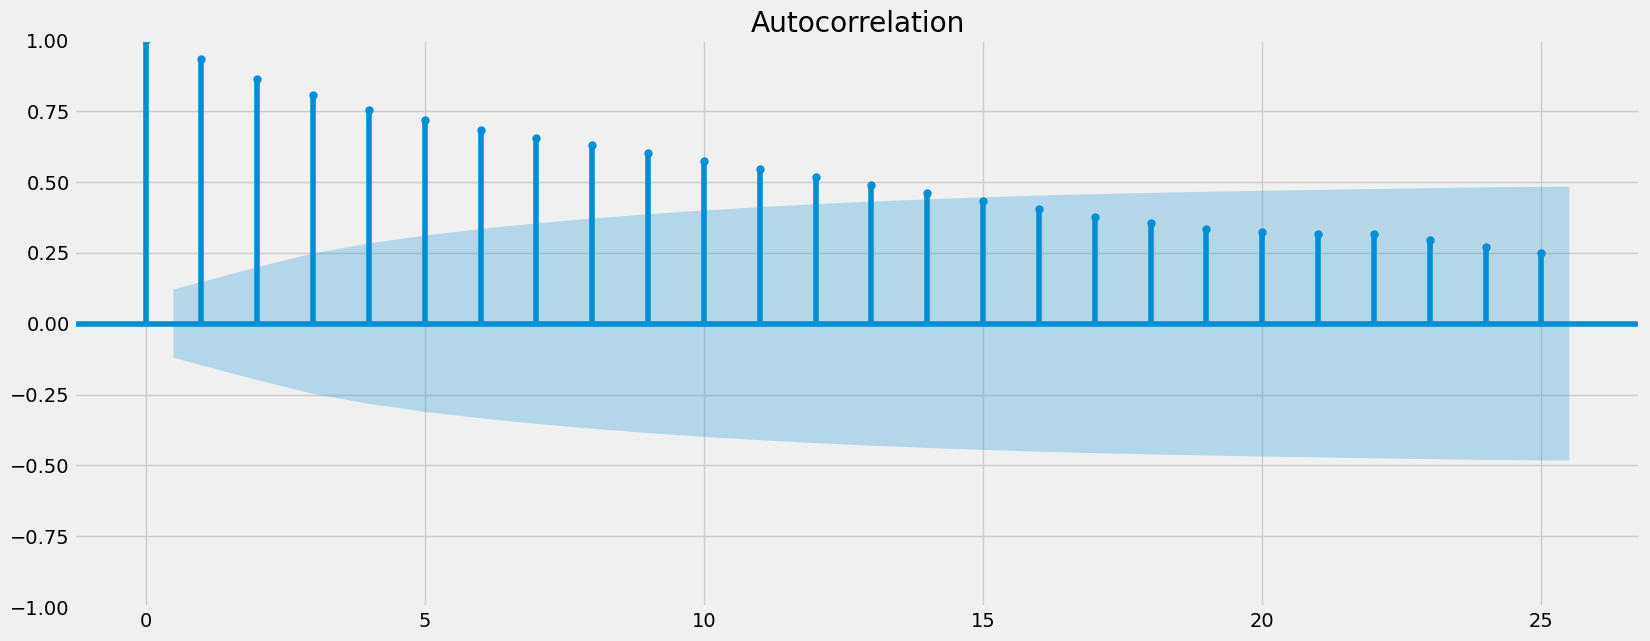

In [202]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_sub)
plt.show()


